## Emissions intensity of the Australian National Electricity Market

*John Morgan, Chief Scientist Pooled Energy, August 2018 | @johnDPMorgan

This notebook constructs a unified dataframe of Australian electricity emissions intensity from 2001 to July 2018 and renders summary charts.

The data is sourced from the Australian Electricity Market Operator (AEMO).

The energy and emissions data is scattered across a lot of files, representing different time period, different emissions methodologies, with different regions being added and removed from the NEM.  Normalising this data is a messy process of dataframe surgery.

This notebook:
* creates a directory 'data' and downloads all the data files from the AEMO website
* extracts and conditions the data to a useful 'long' format into a pandas dataframe
* saves this data to a file data/emissions_intensities_2011_to_2018
* defines a rolling window function, so we can look at eg. 30 day rolling means etc.
* prepares summary charts
* calculates the rate of grid decarbonization

In [1]:
%pylab inline
import datetime as dt
import pandas as pd
import seaborn as sns
import os, shutil, urllib, glob    # for filesystem operations
import matplotlib.dates as mdates  # guess what? matplotlib is special and has its very own date format
from dateutil.parser import parse  # parses date strings
sns.set("talk")  # set the default plot style

Populating the interactive namespace from numpy and matplotlib


### Get the AEMO data
All data is in csv files that can be found linked from AEMO's website at: 

https://www.aemo.com.au/Electricity/National-Electricity-Market-NEM/Settlements-and-payments/Settlements/Carbon-Dioxide-Equivalent-Intensity-Index

Download all these files to ./data

In [2]:
# make a directory to store the data. If directory already exists blow it away and create a new one
try:  
    shutil.rmtree('data')
except OSError:
    None
try:  
    os.mkdir('data')
except OSError:
    None

# list of links current CDEII data files 2011 to now
aemo_CDEII = [
    'http://www.nemweb.com.au/Reports/CURRENT/CDEII/CO2EII_SUMMARY_RESULTS.CSV',
    'https://www.aemo.com.au/-/media/Files/Electricity/NEM/Settlements_and_Payments/Settlements/2018/CO2EII_SUMMARY_RESULTS_2017.CSV',
    'https://www.aemo.com.au/-/media/Files/CSV/CO2EII_SUMMARY_RESULTS_2016.csv',
    'https://www.aemo.com.au/-/media/Files/CSV/CDEII-20160105.csv',
    'https://www.aemo.com.au/-/media/Files/CSV/CO2EII_SUMMARY_RESULTS_2014_PT2.CSV',
    'https://www.aemo.com.au/-/media/Files/CSV/CO2EII_SUMMARY_RESULTS_2014_PT1.CSV',
    'https://www.aemo.com.au/-/media/Files/CSV/CO2EII_SUMMARY_RESULTS_2013.CSV',
    'https://www.aemo.com.au/-/media/Files/CSV/CO2EII_SUMMARY_RESULTS_2012.CSV',
    'https://www.aemo.com.au/-/media/Files/CSV/CO2EII_SUMMARY_RESULTS_2011.CSV'
]

# construct a list of links to the historical snapshot data files 2001 - 2011
aemo_historical = ['https://www.aemo.com.au/-/media/Files/CSV/CO2EII_HISTORICAL_SNAPSHOT_' + str(yr) + '.csv' 
                   for yr in range(2001,2012)]

# download all the data files to the data directory
for url in aemo_CDEII + aemo_historical:
    urllib.urlretrieve(url, 'data/' + url[url.rfind("/")+1:])

### Data munging part I: 

First step is to stitch all the csv files together into a tidy format dataframe df, parse dates and deal with missing data.

Energy is in units MWh

Emissions is units tonne CO2 per day (tCO2/d)

Also get a list the regions ['NSW1', 'NEM', 'SNOWY1', 'VIC1', 'TAS1', 'SA1', 'QLD1']

In [3]:
# data is in form of csv files with the true column headings in the second row
# so I have copy the second row to the df column headings, and dump the second row
# the csv also has a weird non-unique index.  I blow it away and replace it with a numeric index
# finally, all the numbers in this file are actually of type string. They need to be converted to numeric values

df = pd.DataFrame({})                              # create an empty dataframe
for filename in glob.iglob('data/*'):              # for all files in the data directory
    df_temp = pd.read_csv(filename)                # read the csv
    df_temp.index = range(len(df_temp))            # replace the weird index with numbers
    df_temp.drop(labels=0, inplace=True)           # remove the first row (which is now the column headings)
    df_temp = df_temp[df_temp.columns[-5:]]        # the data we want is in the last 5 columns
    df_temp.columns = ['Date', 'Region', 'Energy', 'Emissions', 'Intensity']  #name the columns
    df = df.append(df_temp)                        # add this data to the dataframe

df = df.apply(pd.to_numeric, errors='ignore')      # convert numeric strings to numeric values where possible
df.dropna(inplace=True)                            # clean up NaNs
df.Date = df.Date.apply(parse)                     # convert date strings to datetimes using parse function
df.sort_values(by='Date', inplace=True)            # sort everything by date
df.index = range(len(df))                          # reconstruct the index

# get a list of regions
regions=list(set(df.Region))

### Data munging part II: dealing with TAS1 and SNOWY1 entry and exit
Now some serious dataframe surgery

TAS1 and SNOWY1 are not present for the full time period 2001-2018, so we want to pad out their values so plotting and  functions etc. are happy.

Unfortunately this is not easy with the data in tidy format so it gets a bit messy.

The end result is the cleaned data set, which is written out as a csv and a pickled dataframe

In [16]:
# first create a dataframe of null values for the region TAS1 for days when TAS1 is not represented
no_tas_dates = []
for name, group in df.groupby('Date'):
    if not 'TAS1' in set(group.Region):
        no_tas_dates.append(name)
nans = [float('Nan') for item in no_tas_dates]
tas_null = pd.DataFrame({'Date':no_tas_dates, 
              'Region':['TAS1' for item in nans], 
              'Energy':nans, 
              'Emissions':nans, 
              'Intensity':nans}, 
               index=range(len(df), len(df)+len(no_tas_dates)))

# then do the same for SNOWY1
no_snowy_dates = []
for name, group in df.groupby('Date'):
    if not 'SNOWY1' in set(group.Region):
        no_snowy_dates.append(name)
nans = [float('Nan') for item in no_snowy_dates]
snowy_null = pd.DataFrame({'Date':no_snowy_dates, 
              'Region':['SNOWY1' for item in nans], 
              'Energy':nans, 
              'Emissions':nans, 
              'Intensity':nans}, 
               index=range(len(df), len(df)+len(no_snowy_dates)))

# add these null values to the main dataframe
df1 = df.append(tas_null)    # pad TAS1 with nans
df2 = df1.append(snowy_null) # pad SNOWY1 with nans

# For some reason SNOWY1 is still missing about 36 values which I cbf to fix
# so, resample to 1 day frequency and fill in missing days with the mean value
# The index needs to be set to a date to do this, then the Date column and numeric index restored
df3 = df2[df2.Region=='SNOWY1'].sort_values('Date').set_index('Date').resample('1D').mean()

df3['Date'] = df3.index                                   # Put the date column back
df3.index = range(len(df3))                               # give it a new numeric index
df3['Region'] = ['SNOWY1' for row in range(len(df3))]     # fill in the Region column

# clear snowy values from df2 so as not to get duplicates, then add the resampled ones (df3) back in
df4 = df2[df2.Region != 'SNOWY1'].append(df3)
df4.sort_values(['Date', 'Region'], inplace=True) # sort nicely
df4.index = range(len(df4))                       # order the index
df = df4                                          # and put it back in place

df.to_csv('data/emissions_intensities_2011_to_2018.csv')
df.to_pickle('data/emissions_intensities_2011_to_2018.pkl')

### Function to take a rolling average of a tidy dataframe
The built in rolling window functions don't work on tidy data which interleaves different regions daat into the timeline.

This function breaks out the data by regions, rolls it as requested, then puts it back together again.

In [5]:
def roll(df, window):
    """
    roll the dataframe with a window
    window is number of days for the rolling window
    returns a dataframe which is a rolling average of the input dataframe df
    """
    
    regions=list(set(df.Region))
    df_roll = pd.DataFrame({})              # create an empty dataframe
    df_DI = df.set_index('Date').fillna(0)  # set the index to the date. Fill Nans with zeros so we can take the mean
    
    for region in regions:                  # build the dataframe for each region individually, roll it, and append
        df_roll = df_roll.append(
                        df_DI[df_DI.Region == region]
                            [['Intensity', 'Energy', 'Emissions', 'Region']]
                                .rolling(window)
                                    .mean()
                            )
    df_roll['Date'] = df_roll.index         # recreate the Date column
    df_roll.sort_values(['Date', 'Region'], inplace=True)  # sort it nicely
    df_roll.index = range(len(df_roll))     # and give it a shiny new index
    
    return df_roll

### Plotting: State based histories

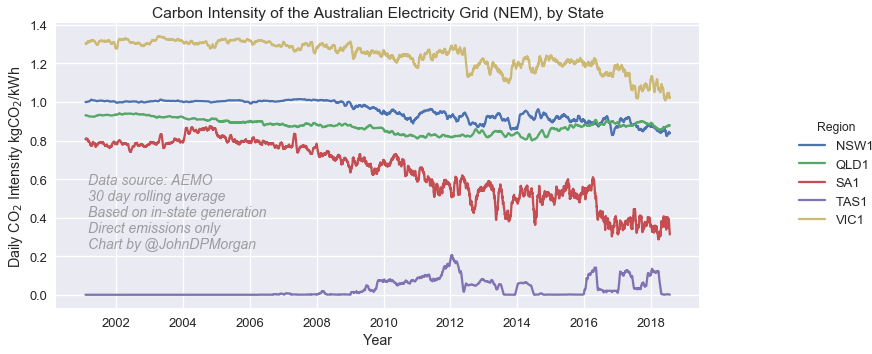

In [6]:
# for legend placement see http://catherineh.github.io/programming/2016/05/24/seaborn-pairgrid-tips
df_roll = roll(df, 30)
g = sns.FacetGrid(df_roll[(df_roll.Region!='NEM') & (df_roll.Region!='SNOWY1')], hue="Region", size=5, aspect=2, legend_out=True)
g.map(plt.plot, "Date", "Intensity")
g.add_legend()
g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))  # move legend outside figure
title('Carbon Intensity of the Australian Electricity Grid (NEM), by State')
ylabel(r'Daily CO$_2$ Intensity kgCO$_2$/kWh')
xlabel('Year')
text(dt.datetime(2001, 3, 1), 0.24, "Data source: AEMO\n30 day rolling average\nBased on in-state generation\nDirect emissions only\nChart by @JohnDPMorgan", alpha=0.4, fontsize=14, style='italic')

### Carbon intensity of the grid, with generator intensities for reference
30 day rolling average with a drop highlight

Emissions intensities approximate ranges from charts in https://www.aemo.com.au/-/media/Files/PDF/20140411_Emissions_report_V2.pdf

* Brown coal 1.0 - 1.4 tCO2/MWh
* Black coal 0.8 - 0.95
* CCGT 0.35 - 0.5
* OCGT 0.5 - 0.9

In [8]:
# create parameters to draw rectangles on the plot using dates as coordinates
# create rectangle x coordinates
startTime = dt.datetime(2000,1,1)
endTime = startTime + dt.timedelta(days = 20 * 365)

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start

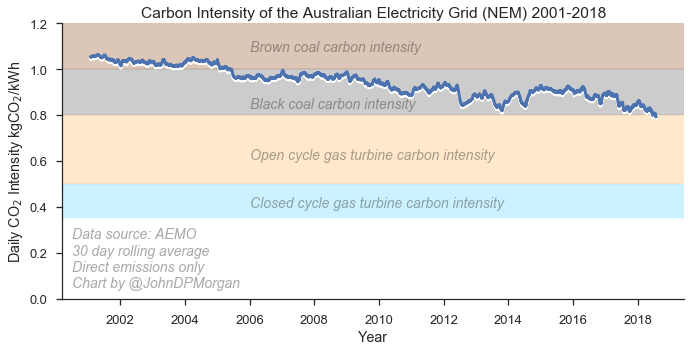

In [9]:
# main plot
df_roll = roll(df, 30)                           # work with a 30 day rolling average
df_roll['Highlight'] = df_roll.Intensity - 0.01  # create a drop highlight for the data line
sns.set_style("ticks")
g = sns.FacetGrid(df_roll[df_roll.Region=='NEM'], hue="Region", size=5, aspect=2, legend_out=True)
g.map(plt.plot, "Date", "Highlight", **dict(linewidth=3, color='white'))
g.map(plt.plot, "Date", "Intensity", **dict(linewidth=3))
#g.fig.get_children()[-1].set_bbox_to_anchor((0.2, 0.5, 0, 0))  # position legend
ylim(0,1.2)
title('Carbon Intensity of the Australian Electricity Grid (NEM) 2001-2018')
ylabel(r'Daily CO$_2$ Intensity kgCO$_2$/kWh')
xlabel('Year')
text(dt.datetime(2000, 7, 1), 0.05, 
     "Data source: AEMO\n30 day rolling average\nDirect emissions only\nChart by @JohnDPMorgan", 
     alpha=0.4, fontsize=14, style='italic')

# Plot the generator ranges
g.axes[0][0].add_patch(Rectangle((start, 1.0),  width, 0.4,  **{'zorder':1, 'alpha':0.3, 'color':'saddlebrown'}))
g.axes[0][0].add_patch(Rectangle((start, 0.8),  width, 0.2, **{'zorder':1, 'alpha':0.2, 'color':'black'}))
g.axes[0][0].add_patch(Rectangle((start, 0.5),  width, 0.3,  **{'zorder':1, 'alpha':0.2, 'color':'darkorange'}))
g.axes[0][0].add_patch(Rectangle((start, 0.35), width, 0.15, **{'zorder':1, 'alpha':0.2, 'color':'deepskyblue'}))
text(dt.datetime(2006, 1, 1), 1.08, "Brown coal carbon intensity", alpha=0.4, fontsize=14, style='italic')
text(dt.datetime(2006, 1, 1), 0.83, "Black coal carbon intensity", alpha=0.4, fontsize=14, style='italic')
text(dt.datetime(2006, 1, 1), 0.61, "Open cycle gas turbine carbon intensity", alpha=0.4, fontsize=14, style='italic')
text(dt.datetime(2006, 1, 1), 0.40, "Closed cycle gas turbine carbon intensity", alpha=0.4, fontsize=14, style='italic')
sns.set_style("darkgrid")  # restore to default seaborn style

### Energy delivered by the grid

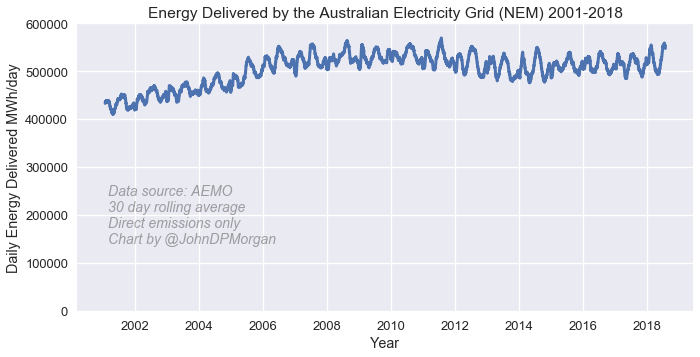

In [10]:
df_roll = roll(df, 30)
g = sns.FacetGrid(df_roll[df_roll.Region=='NEM'], hue="Region", size=5, aspect=2, legend_out=True)
g.map(plt.plot, "Date", "Energy", **dict(linewidth=3))
ylim(0,600000)
title('Energy Delivered by the Australian Electricity Grid (NEM) 2001-2018')
ylabel(r'Daily Energy Delivered MWh/day')
xlabel('Year')
text(dt.datetime(2001, 3, 1), 140000, 
     "Data source: AEMO\n30 day rolling average\nDirect emissions only\nChart by @JohnDPMorgan", 
     alpha=0.4, fontsize=14, style='italic')

### Grid carbon emissions

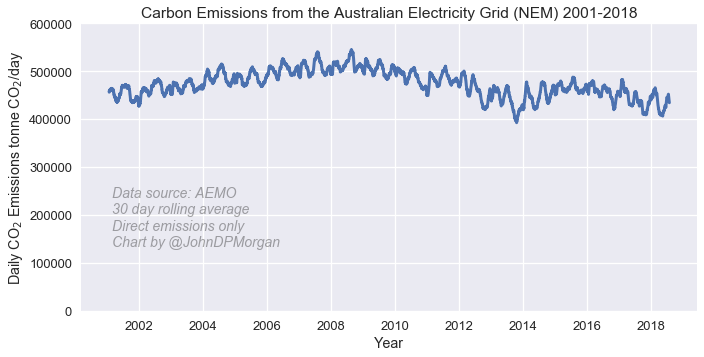

In [11]:
df_roll = roll(df, 30)
g = sns.FacetGrid(df_roll[df_roll.Region=='NEM'], hue="Region", size=5, aspect=2, legend_out=True)
g.map(plt.plot, "Date", "Emissions", **dict(linewidth=3))
#g.fig.get_children()[-1].set_bbox_to_anchor((0.2, 0.5, 0, 0))  # position legend
ylim(0,600000)
title('Carbon Emissions from the Australian Electricity Grid (NEM) 2001-2018')
ylabel(r'Daily CO$_2$ Emissions tonne CO$_2$/day')
xlabel('Year')
text(dt.datetime(2001, 3, 1), 135000, 
     "Data source: AEMO\n30 day rolling average\nDirect emissions only\nChart by @JohnDPMorgan", 
     alpha=0.4, fontsize=14, style='italic')

### Rate of decarbonization

In [24]:
# calculate the rate of decarbonization using linear regression.  Use sklearn to do the linear regresion
from sklearn.linear_model import LinearRegression 

# prep the data - arrays of intensity and day
days = (df[df.Region == 'NEM'].Date - dt.datetime(2001,1,1,0,0,0)).apply(lambda x: x.days).values.reshape(-1, 1)
intensity = df[df.Region == 'NEM'].Intensity.values.reshape(-1, 1)

regressor = LinearRegression()  
regressor.fit(days, intensity)
decarb = regressor.coef_*365/intensity.mean()

print 'Historical grid decarbonization rate is', round(-decarb[0][0], 3), 'kgCO2 per kWh per year'

Historical grid decarbonization rate is 0.013 kgCO2 per kWh per year
